<a href="https://colab.research.google.com/github/kaviyan-2005/cm2604-telco-churn/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Run once in Colab (uncomment if needed)
# !pip install -q scikit-learn imbalanced-learn matplotlib seaborn tensorflow keras keras-tuner joblib xgboost


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
RANDOM_STATE = 42


In [4]:
# Path - change if you uploaded elsewhere
DATA_PATH = "telco_customer_churn.csv"

if not os.path.exists(DATA_PATH):
    print("Run this cell after uploading 'telco_customer_churn.csv' to the data/ directory or update DATA_PATH.")
else:
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataset: ", df.shape)
    display(df.head())


Loaded dataset:  (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Basic info
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nClass distribution (Churn):")
print(df['Churn'].value_counts(normalize=False))
print(df['Churn'].value_counts(normalize=True))

# Summary stats
display(df.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


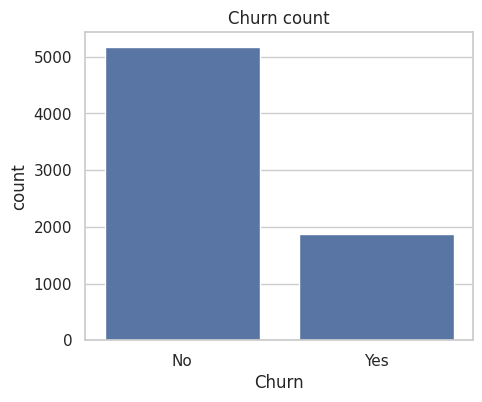

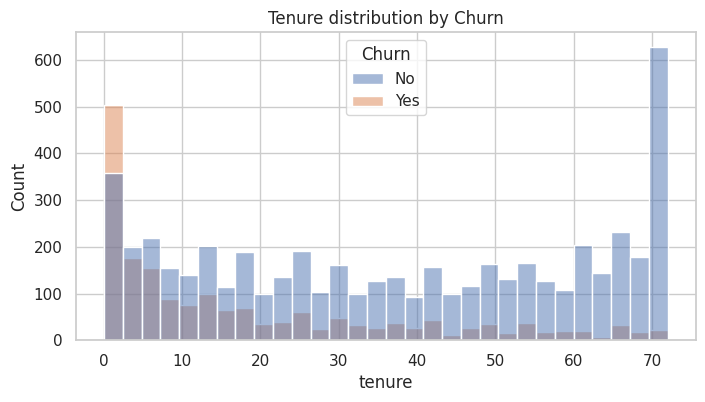

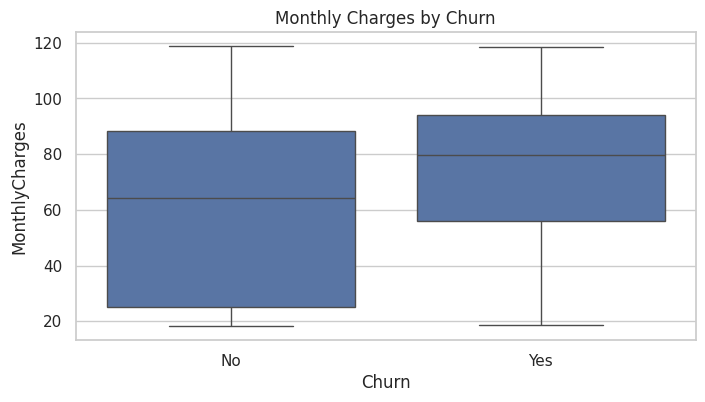

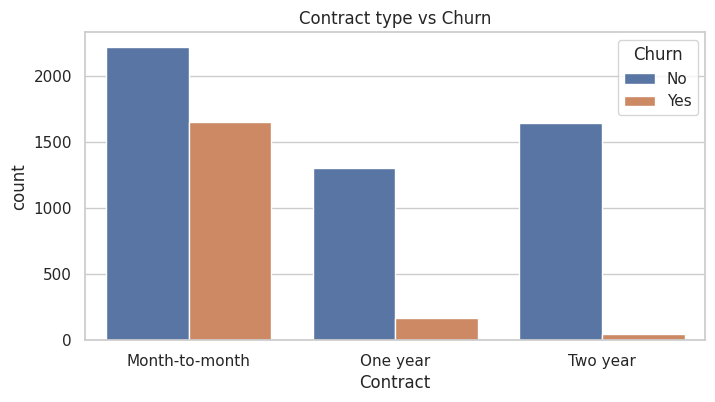

In [6]:
# Numeric distributions
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Plot churn counts
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn count')
plt.show()

# Tenure distribution by churn
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=False, bins=30)
plt.title('Tenure distribution by Churn')
plt.show()

# MonthlyCharges by churn
plt.figure(figsize=(8,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges by Churn')
plt.show()

# Categorical features: example - Contract
plt.figure(figsize=(8,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract type vs Churn')
plt.show()


In [7]:
# Drop customerID, convert total charges to numeric (some blanks)
df = df.copy()
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric (coerce errors)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Churn') if 'Churn' in cat_cols else None

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Fill missing numeric with median
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Encode target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(int)

# One-hot encode categorical variables (drop_first to avoid multicollinearity)
df_processed = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("After one-hot encoding shape:", df_processed.shape)
display(df_processed.head())


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
After one-hot encoding shape: (7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [8]:
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Test:", X_test.shape)

# Scale numeric features - find numeric columns again
num_cols_scaled = [c for c in X.columns if df_processed[c].dtype in [np.float64, np.int64]]
scaler = StandardScaler()
X_train[num_cols_scaled] = scaler.fit_transform(X_train[num_cols_scaled])
X_test[num_cols_scaled] = scaler.transform(X_test[num_cols_scaled])


Train: (5634, 30) Test: (1409, 30)


In [9]:
print("Before SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [10]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [3,5,7,10,15, None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,4,8],
    'criterion': ['gini','entropy']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_dt = GridSearchCV(dt, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid_dt.fit(X_train_res, y_train_res)
print("Best params:", grid_dt.best_params_)
dt_best = grid_dt.best_estimator_


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


Decision Tree — Classification Report:
              precision    recall  f1-score   support

           0     0.8581    0.7478    0.7992      1035
           1     0.4852    0.6578    0.5585       374

    accuracy                         0.7239      1409
   macro avg     0.6717    0.7028    0.6788      1409
weighted avg     0.7591    0.7239    0.7353      1409

ROC AUC: 0.7435570539151102


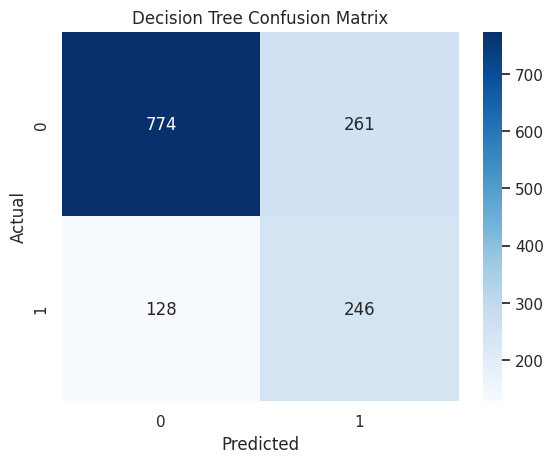

In [11]:
y_pred_dt = dt_best.predict(X_test)
print("Decision Tree — Classification Report:")
print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC AUC:", roc_auc_score(y_test, dt_best.predict_proba(X_test)[:,1]))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
def build_model(input_shape, hp_units=64, hp_dropout=0.3, lr=1e-3):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(input_shape,)),
        layers.Dense(hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_units//2, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc'),
                           'accuracy'])
    return model

input_shape = X_train_res.shape[1]
nn = build_model(input_shape, hp_units=128, hp_dropout=0.3, lr=1e-3)
nn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, mode='max')

history = nn.fit(X_train_res, y_train_res,
                 validation_split=0.2,
                 epochs=100,
                 batch_size=128,
                 callbacks=[es, rlr],
                 verbose=1)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6810 - auc: 0.7304 - loss: 0.5822 - val_accuracy: 0.6769 - val_auc: 0.0000e+00 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7643 - auc: 0.8290 - loss: 0.4922 - val_accuracy: 0.6993 - val_auc: 0.0000e+00 - val_loss: 0.6487 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7798 - auc: 0.8509 - loss: 0.4593 - val_accuracy: 0.7204 - val_auc: 0.0000e+00 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7795 - auc: 0.8487 - loss: 0.4660 - val_accuracy: 0.6854 - val_auc: 0.0000e+00 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7828 - auc: 0.8544 - loss: 0.4558 - val_accuracy: 0.7059 - val_auc: 0.0000e+00 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network — Classification Report:
              precision    recall  f1-score   support

           0     0.8720    0.8097    0.8397      1035
           1     0.5603    0.6711    0.6107       374

    accuracy                         0.7729      1409
   macro avg     0.7161    0.7404    0.7252      1409
weighted avg     0.7893    0.7729    0.7789      1409

ROC AUC: 0.8315843860600894


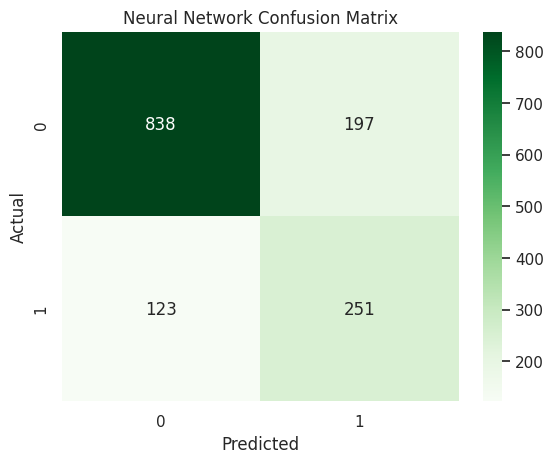

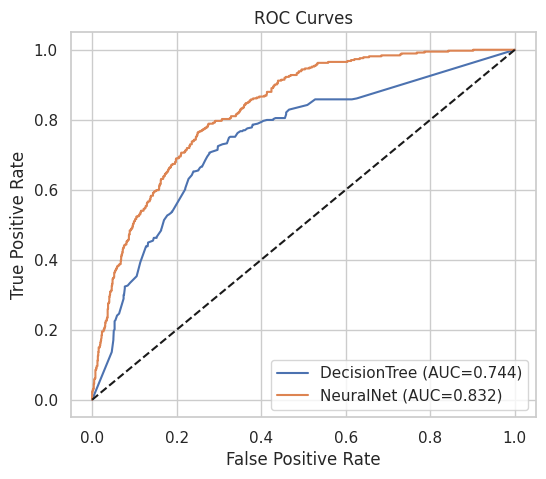

In [14]:
y_proba_nn = nn.predict(X_test).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

print("Neural Network — Classification Report:")
print(classification_report(y_test, y_pred_nn, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nn))

cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve for both models
from sklearn.metrics import roc_curve, auc
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_best.predict_proba(X_test)[:,1])
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f'DecisionTree (AUC={auc(fpr_dt,tpr_dt):.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NeuralNet (AUC={auc(fpr_nn,tpr_nn):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.show()


In [15]:
!pip install scikeras


In [16]:
from scikeras.wrappers import KerasClassifier


In [17]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


In [18]:
# best_nn = rs.best_estimator_.model_


In [19]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(hp_units=128, hp_dropout=0.3, lr=1e-3):
    m = keras.Sequential([
        layers.InputLayer(input_shape=(input_shape,)),
        layers.Dense(hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(max(32,hp_units//2), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m

clf = KerasClassifier(model=create_model, epochs=30, batch_size=128, verbose=0, optimizer='adam')
param_dist = {
    "model__hp_units": [64, 128, 256],
    "model__hp_dropout": [0.2, 0.3, 0.4],
    "model__lr": [1e-3, 1e-4]
}
rs = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=6,
                        scoring='f1', cv=3, random_state=RANDOM_STATE, verbose=2, n_jobs=1)
# NOTE: This can be slow — optional
# rs.fit(X_train_res, y_train_res)
# print("Best params NN:", rs.best_params_)
# best_nn = rs.best_estimator_.model_


In [20]:
# Save sklearn model
joblib.dump(dt_best, "dt_best.joblib")
# Save scaler
joblib.dump(scaler, "scaler.joblib")
# Save Keras model
nn.save("nn_best.h5")

print("Saved dt_best.joblib, scaler.joblib, nn_best.h5")


Saved dt_best.joblib, scaler.joblib, nn_best.h5


In [21]:
def predict_customer(sample_df):
    # sample_df: dataframe with same columns as X (single row)
    s = sample_df.copy()
    s[num_cols_scaled] = scaler.transform(s[num_cols_scaled])
    proba_dt = dt_best.predict_proba(s)[:,1][0]
    proba_nn = float(nn.predict(s)[0][0])
    return {"DecisionTree_proba": proba_dt, "NeuralNet_proba": proba_nn}

# Example usage (use first test row)
sample = X_test.iloc[[0]]
print(predict_customer(sample))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{'DecisionTree_proba': np.float64(0.0), 'NeuralNet_proba': 0.10412218421697617}


In [22]:
import pandas as pd
import numpy as np

def load_and_preprocess(path):
    df = pd.read_csv(path)
    if 'customerID' in df.columns:
        df.drop('customerID', axis=1, inplace=True)
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
    df['Churn'] = df['Churn'].map({'Yes':1,'No':0}).astype(int)
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'Churn' in cat_cols:
        cat_cols.remove('Churn')
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df


In [23]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers

def build_dt(params=None):
    if params is None:
        params = {}
    return DecisionTreeClassifier(**params)

def build_nn(input_shape, hp_units=128, hp_dropout=0.3, lr=1e-3):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(input_shape,)),
        layers.Dense(hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(max(32, hp_units//2), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [24]:
# ----- FINAL MODEL COMPARISON OUTPUT -----

# Calculate metrics for Decision Tree
dt_proba = dt_best.predict_proba(X_test)[:, 1]
dt_pred = dt_best.predict(X_test)

dt_f1 = f1_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_proba)

# Calculate metrics for Neural Network
nn_proba = nn.predict(X_test).ravel()
nn_pred = (nn_proba >= 0.5).astype(int)

nn_f1 = f1_score(y_test, nn_pred)
nn_auc = roc_auc_score(y_test, nn_proba)

print("========== FINAL MODEL PERFORMANCE COMPARISON ==========\n")
print(f"Decision Tree:")
print(f"   F1-score: {dt_f1:.4f}")
print(f"   ROC-AUC:  {dt_auc:.4f}\n")

print(f"Neural Network:")
print(f"   F1-score: {nn_f1:.4f}")
print(f"   ROC-AUC:  {nn_auc:.4f}\n")

# Decide best model
if nn_f1 > dt_f1 and nn_auc > dt_auc:
    best = "Neural Network"
elif dt_f1 > nn_f1 and dt_auc > nn_auc:
    best = "Decision Tree"
else:
    best = "Mixed — depends on metric"

print("========================================================")
print(f"BEST MODEL BASED ON TEST PERFORMANCE: ** {best} **")
print("========================================================")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
========== FINAL MODEL PERFORMANCE COMPARISON ==========

Decision Tree:
   F1-score: 0.5585
   ROC-AUC:  0.7436

Neural Network:
   F1-score: 0.6107
   ROC-AUC:  0.8316

BEST MODEL BASED ON TEST PERFORMANCE: ** Neural Network **
